In [1]:
import os
import gensim
from gensim import utils
from tqdm.notebook import tqdm
from sklearn.neighbors import kneighbors_graph
from sklearn import metrics
from sklearn.preprocessing import minmax_scale, LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import k_means, SpectralClustering
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import pandas as pd

In [2]:
class Dataloader:
    def __iter__(self):
        for genre in tqdm(['ballads', 'elegies', 'songs', 'novels'], leave=True):
            for file in tqdm(os.listdir('../datasets/lemmatized/' + genre), leave=False):
                with open('../datasets/lemmatized/' + genre + '/' + file, 'r', encoding='utf-8') as f:
                    yield utils.simple_preprocess(f.read()), genre
sentences = Dataloader()

In [ ]:
#word2vec = gensim.models.Word2Vec(sentences=sentences, vector_size=128, min_count=1)

In [3]:
#word2vec.save('word2vec_model')
word2vec = gensim.models.Word2Vec.load('word2vec_model')
wv = word2vec.wv

In [4]:
#np.random.seed(0)
#random_num = np.random.randint(1826, size=100)
graphs = []
text_len = []
true_labels = []

for num_sentence, (sentence, genre) in enumerate(sentences):
    #if num_sentence not in random_num:
    #    continue
    if not sentence:
        continue
    true_labels.append(genre)
    text_len.append(len(sentence))
    node_type = dict()
    edge_type = dict()
    node_weight = dict()
    nodes = []
    edges = []
    weights = []
    counter = Counter(sentence)
    top10 = counter.most_common(10)
    for word_i, count in top10:
        nodes.append(word_i)
        node_weight[word_i] = count / len(sentence)
        node_type[word_i] = 'core'
        words_in_text = np.array(list(set(sentence)))
        sim = wv.cosine_similarities(wv[word_i], wv[words_in_text])
        neigh_idx = np.argsort(sim)[-11:-1]
        for j in neigh_idx:
            word_j = words_in_text[j]
            if word_j not in nodes:
                nodes.append(word_j)
                node_weight[word_j] = counter[word_j] / len(sentence)
            edges.append([word_i, word_j, sim[j]])
    graph = nx.Graph()
    graph.add_nodes_from(nodes)
    graph.add_weighted_edges_from(edges)
    for node, degree in graph.degree:
        if degree == 1:
            node_type[node] = 'boundary'
    for node in set(graph.nodes).difference(node_type.keys()):
        node_type[node] = 'multiple'
    nx.set_node_attributes(graph, node_type, 'node_type')
    nx.set_node_attributes(graph, node_weight, 'node_weight')
    for (u, v) in graph.edges:
        types = set(nx.get_node_attributes(graph.subgraph([u, v]), 'node_type').values())
        if types == {'core'}:
            edge_type[(u, v)] = 'core'
        elif types == {'core', 'multiple'}:
            edge_type[(u, v)] = 'multiple'
        else:
            edge_type[(u, v)] = 'boundary'
    nx.set_edge_attributes(graph, edge_type, 'edge_type')
    graphs.append(graph)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/189 [00:00<?, ?it/s]

  0%|          | 0/509 [00:00<?, ?it/s]

  0%|          | 0/623 [00:00<?, ?it/s]

  0%|          | 0/506 [00:00<?, ?it/s]

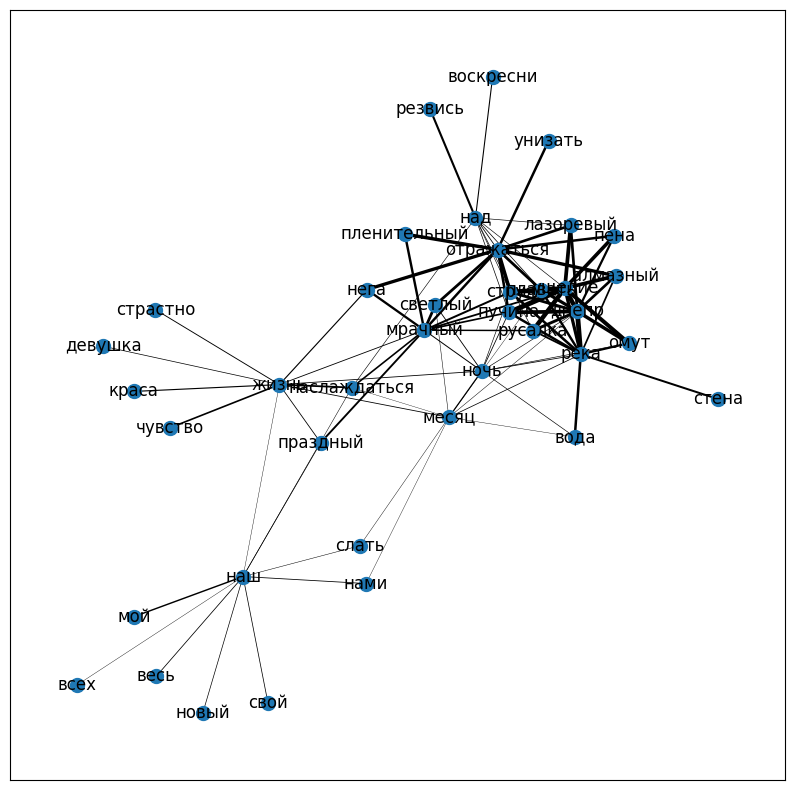

In [101]:
plt.figure(figsize=(10, 10))
graph = nx.Graph(graphs[10])
#cc_nodes = list(nx.connected_components(graph))[0]
#subgraph = graph.subgraph(cc_nodes)
weights = np.array(list(nx.get_edge_attributes(graph, 'weight').values()))
nx.draw_networkx(graph, node_size=100, width=(weights + 0.5)**4)

In [6]:
core_edges = []
multiple_edges = []
boundary_edges = []
multiple_nodes = []
boundary_nodes = []

min_core_node_weight = []
max_core_node_weight = []
avg_core_node_weight = []
sum_core_node_weight = []
min_multiple_node_weight = []
max_multiple_node_weight = []
avg_multiple_node_weight = []
sum_multiple_node_weight = []
min_boundary_node_weight = []
max_boundary_node_weight = []
avg_boundary_node_weight = []
sum_boundary_node_weight = []

min_core_edge_weight = []
max_core_edge_weight = []
avg_core_edge_weight = []
sum_core_edge_weight = []
min_multiple_edge_weight = []
max_multiple_edge_weight = []
avg_multiple_edge_weight = []
sum_multiple_edge_weight = []
min_boundary_edge_weight = []
max_boundary_edge_weight = []
avg_boundary_edge_weight = []
sum_boundary_edge_weight = []

min_core_core_degree = []
max_core_core_degree = []
avg_core_core_degree = []
sum_core_core_degree = []
min_core_multiple_degree = []
max_core_multiple_degree = []
avg_core_multiple_degree = []
sum_core_multiple_degree = []
min_core_boundary_degree = []
max_core_boundary_degree = []
avg_core_boundary_degree = []
sum_core_boundary_degree = []

for graph in tqdm(graphs):
    edge_counter = Counter(nx.get_edge_attributes(graph, 'edge_type').values())
    node_counter = Counter(nx.get_node_attributes(graph, 'node_type').values())
    core_edges.append(edge_counter['core'])
    multiple_edges.append(edge_counter['multiple'])
    boundary_edges.append(edge_counter['boundary'])
    multiple_nodes.append(node_counter['multiple'])
    boundary_nodes.append(node_counter['boundary'])
    
    # node aggregation
    core_node_weight = []
    multiple_node_weight = []
    boundary_node_weight = []
    for node in graph.nodes:
        if graph.nodes[node]['node_type'] == 'core':
            core_node_weight.append(graph.nodes[node]['node_weight'])
        elif graph.nodes[node]['node_type'] == 'multiple':
            multiple_node_weight.append(graph.nodes[node]['node_weight'])
        else:
            boundary_node_weight.append(graph.nodes[node]['node_weight'])
    min_core_node_weight.append(min(core_node_weight))
    max_core_node_weight.append(max(core_node_weight))
    avg_core_node_weight.append(np.mean(core_node_weight))
    sum_core_node_weight.append(sum(core_node_weight))
    min_multiple_node_weight.append(min(multiple_node_weight))
    max_multiple_node_weight.append(max(multiple_node_weight))
    avg_multiple_node_weight.append(np.mean(multiple_node_weight))
    sum_multiple_node_weight.append(sum(multiple_node_weight))
    boundary_node_weight = [0] if not boundary_node_weight else boundary_node_weight
    min_boundary_node_weight.append(min(boundary_node_weight))
    max_boundary_node_weight.append(max(boundary_node_weight))
    avg_boundary_node_weight.append(np.mean(boundary_node_weight))
    sum_boundary_node_weight.append(sum(boundary_node_weight))
    
    # edge aggregation
    core_edge_weight = []
    multiple_edge_weight = []
    boundary_edge_weight = []
    for edge in graph.edges:
        if graph.edges[edge]['edge_type'] == 'core':
            core_edge_weight.append(graph.edges[edge]['weight'])
        elif graph.edges[edge]['edge_type'] == 'multiple':
            multiple_edge_weight.append(graph.edges[edge]['weight'])
        else:
            boundary_edge_weight.append(graph.edges[edge]['weight'])
    core_edge_weight = [0] if not core_edge_weight else core_edge_weight
    min_core_edge_weight.append(min(core_edge_weight))
    max_core_edge_weight.append(max(core_edge_weight))
    avg_core_edge_weight.append(np.mean(core_edge_weight))
    sum_core_edge_weight.append(sum(core_edge_weight))
    min_multiple_edge_weight.append(min(multiple_edge_weight))
    max_multiple_edge_weight.append(max(multiple_edge_weight))
    avg_multiple_edge_weight.append(np.mean(multiple_edge_weight))
    sum_multiple_edge_weight.append(sum(multiple_edge_weight))
    boundary_edge_weight = [0] if not boundary_edge_weight else boundary_edge_weight
    min_boundary_edge_weight.append(min(boundary_edge_weight))
    max_boundary_edge_weight.append(max(boundary_edge_weight))
    avg_boundary_edge_weight.append(np.mean(boundary_edge_weight))
    sum_boundary_edge_weight.append(sum(boundary_edge_weight))
    
    # degree aggregation
    core_core_degree = []
    core_multiple_degree = []
    core_boundary_degree = []
    for core_node in graph.nodes:
        if graph.nodes[core_node]['node_type'] != 'core':
            continue
        degree_counter = Counter([value for (u, v, value) in graph.edges(core_node, data='edge_type')])
        core_core_degree.append(degree_counter['core'])
        core_multiple_degree.append(degree_counter['multiple'])
        core_boundary_degree.append(degree_counter['boundary'])
    
    min_core_core_degree.append(min(core_core_degree))
    max_core_core_degree.append(max(core_core_degree))
    avg_core_core_degree.append(np.mean(core_core_degree))
    sum_core_core_degree.append(sum(core_core_degree))
    min_core_multiple_degree.append(min(core_multiple_degree))
    max_core_multiple_degree.append(max(core_multiple_degree))
    avg_core_multiple_degree.append(np.mean(core_multiple_degree))
    sum_core_multiple_degree.append(sum(core_multiple_degree))
    core_boundary_degree = [0] if not core_boundary_degree else core_boundary_degree
    min_core_boundary_degree.append(min(core_boundary_degree))
    max_core_boundary_degree.append(max(core_boundary_degree))
    avg_core_boundary_degree.append(np.mean(core_boundary_degree))
    sum_core_boundary_degree.append(sum(core_boundary_degree))

  0%|          | 0/1826 [00:00<?, ?it/s]

In [7]:
graph_feat = pd.DataFrame({
    'text_len': text_len,
    'core_edges': core_edges,
    'multiple_edges': multiple_edges,
    'boundary_edges': boundary_edges,
    'multiple_nodes': multiple_nodes,
    'boundary_nodes': boundary_nodes,
    'min_core_node_weight': min_core_node_weight,
    'max_core_node_weight': max_core_node_weight,
    'avg_core_node_weight': avg_core_node_weight,
    'sum_core_node_weight': sum_core_node_weight,
    'min_multiple_node_weight': min_multiple_node_weight,
    'max_multiple_node_weight': max_multiple_node_weight,
    'avg_multiple_node_weight': avg_multiple_node_weight,
    'sum_multiple_node_weight': sum_multiple_node_weight,
    'min_boundary_node_weight': min_boundary_node_weight,
    'max_boundary_node_weight': max_boundary_node_weight,
    'avg_boundary_node_weight': avg_boundary_node_weight,
    'sum_boundary_node_weight': sum_boundary_node_weight,
    'min_core_edge_weight': min_core_edge_weight,
    'max_core_edge_weight': max_core_edge_weight,
    'avg_core_edge_weight': avg_core_edge_weight,
    'sum_core_edge_weight': sum_core_edge_weight,
    'min_multiple_edge_weight': min_multiple_edge_weight,
    'max_multiple_edge_weight': max_multiple_edge_weight,
    'avg_multiple_edge_weight': avg_multiple_edge_weight,
    'sum_multiple_edge_weight': sum_multiple_edge_weight,
    'min_boundary_edge_weight': min_boundary_edge_weight,
    'max_boundary_edge_weight': max_boundary_edge_weight,
    'avg_boundary_edge_weight': avg_boundary_edge_weight,
    'sum_boundary_edge_weight': sum_boundary_edge_weight,
    'min_core_core_degree': min_core_core_degree,
    'max_core_core_degree': max_core_core_degree,
    'avg_core_core_degree': avg_core_core_degree,
    'sum_core_core_degree': sum_core_core_degree,
    'min_core_multiple_degree': min_core_multiple_degree,
    'max_core_multiple_degree': max_core_multiple_degree,
    'avg_core_multiple_degree': avg_core_multiple_degree,
    'sum_core_multiple_degree': sum_core_multiple_degree,
    'min_core_boundary_degree': min_core_boundary_degree,
    'max_core_boundary_degree': max_core_boundary_degree,
    'avg_core_boundary_degree': avg_core_boundary_degree,
    'sum_core_boundary_degree': sum_core_boundary_degree,
})
graph_feat.iloc[0]

text_len                    217.000000
core_edges                   21.000000
multiple_edges               37.000000
boundary_edges               24.000000
multiple_nodes               11.000000
boundary_nodes               24.000000
min_core_node_weight          0.023041
max_core_node_weight          0.036866
avg_core_node_weight          0.029032
sum_core_node_weight          0.290323
min_multiple_node_weight      0.004608
max_multiple_node_weight      0.009217
avg_multiple_node_weight      0.007122
sum_multiple_node_weight      0.078341
min_boundary_node_weight      0.004608
max_boundary_node_weight      0.023041
avg_boundary_node_weight      0.007680
sum_boundary_node_weight      0.184332
min_core_edge_weight          0.732022
max_core_edge_weight          0.958177
avg_core_edge_weight          0.856555
sum_core_edge_weight         17.987651
min_multiple_edge_weight      0.404699
max_multiple_edge_weight      0.862086
avg_multiple_edge_weight      0.733216
sum_multiple_edge_weight 

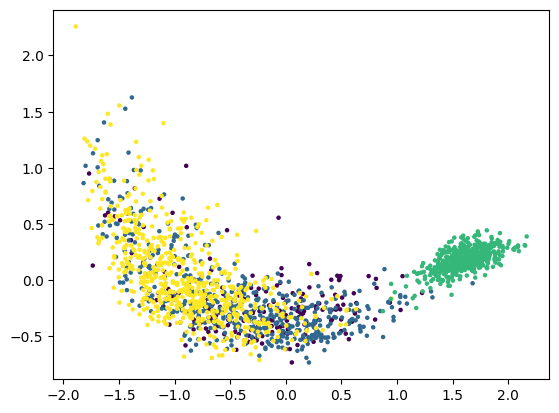

In [8]:
pca = PCA(n_components=16)
emb = pca.fit_transform(minmax_scale(graph_feat))
plt.scatter(emb[:, 0], emb[:, 1], c=LabelEncoder().fit_transform(true_labels), s=5)

In [9]:
clustering = SpectralClustering(
    n_clusters=4, 
    n_neighbors=6,
    affinity='nearest_neighbors',
    assign_labels='kmeans',
)
pred_labels = clustering.fit_predict(emb)

In [10]:
print(
f'''homogeneity_score: {metrics.homogeneity_score(true_labels, pred_labels):.4f}
completeness_score: {metrics.completeness_score(true_labels, pred_labels):.4f}
v_measure_score: {metrics.v_measure_score(true_labels, pred_labels):.4f}
adjusted_rand_score: {metrics.adjusted_rand_score(true_labels, pred_labels):.4f}'''
)

homogeneity_score: 0.4405
completeness_score: 0.7088
v_measure_score: 0.5433
adjusted_rand_score: 0.3206


In [11]:
graph_words = []
jaccard = []

for graph in graphs:
    nodes = [node for node in graph.nodes]
    graph_words.append(set(nodes))

for set_1 in graph_words:
    jaccard_row = []
    for set_2 in graph_words:
        jaccard_pair = gensim.matutils.jaccard_distance(set_1, set_2)
        jaccard_row.append(jaccard_pair)
    jaccard.append(jaccard_row)

In [14]:
clustering_ = SpectralClustering(
    n_clusters=4, 
    n_neighbors=6,
    assign_labels='kmeans',
    affinity = 'precomputed',
)
jaccard_labels = clustering_.fit_predict(minmax_scale(np.array(jaccard)))
print(
f'''homogeneity_score: {metrics.homogeneity_score(true_labels, jaccard_labels):.4f}
completeness_score: {metrics.completeness_score(true_labels, jaccard_labels):.4f}
v_measure_score: {metrics.v_measure_score(true_labels, jaccard_labels):.4f}
adjusted_rand_score: {metrics.adjusted_rand_score(true_labels, jaccard_labels):.4f}'''
)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:248: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)


homogeneity_score: 0.0019
completeness_score: 0.0993
v_measure_score: 0.0037
adjusted_rand_score: 0.0006


In [15]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4)
concat_labels = kmeans.fit_predict(np.column_stack((pred_labels, jaccard_labels)))
print(
f'''homogeneity_score: {metrics.homogeneity_score(true_labels, concat_labels):.4f}
completeness_score: {metrics.completeness_score(true_labels, concat_labels):.4f}
v_measure_score: {metrics.v_measure_score(true_labels, concat_labels):.4f}
adjusted_rand_score: {metrics.adjusted_rand_score(true_labels, concat_labels):.4f}'''
)

homogeneity_score: 0.4236
completeness_score: 0.6860
v_measure_score: 0.5238
adjusted_rand_score: 0.3185


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [16]:
graph_feat_jaccard = clustering.fit_predict(minmax_scale(np.column_stack((graph_feat, jaccard_labels))))
print(
f'''homogeneity_score: {metrics.homogeneity_score(true_labels, graph_feat_jaccard):.4f}
completeness_score: {metrics.completeness_score(true_labels, graph_feat_jaccard):.4f}
v_measure_score: {metrics.v_measure_score(true_labels, graph_feat_jaccard):.4f}
adjusted_rand_score: {metrics.adjusted_rand_score(true_labels, graph_feat_jaccard):.4f}'''
)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


homogeneity_score: 0.4827
completeness_score: 0.5754
v_measure_score: 0.5250
adjusted_rand_score: 0.4663


In [40]:
graph_feat.to_csv('graph_feat.csv', index=False)

genre clusterization with stopword removal
SpaCy stopwords https://github.com/explosion/spaCy/blob/master/spacy/lang/ru/stop_words.py

In [102]:
STOP_WORDS = set(
    """
а авось ага агу аж ай али алло ау ах ая

б будем будет будете будешь буду будут будучи будь будьте бы был была были было
быть бац без безусловно бишь благо благодаря ближайшие близко более больше
будто бывает бывала бывали бываю бывают бытует

в вам вами вас весь во вот все всё всего всей всем всём всеми всему всех всею
всея всю вся вы ваш ваша ваше ваши вдали вдобавок вдруг ведь везде вернее
взаимно взаправду видно вишь включая вместо внакладе вначале вне вниз внизу
вновь вовсе возможно воистину вокруг вон вообще вопреки вперекор вплоть
вполне вправду вправе впрочем впрямь вресноту вроде вряд всегда всюду
всякий всякого всякой всячески вчеред

г го где гораздо гав

д да для до дабы давайте давно давным даже далее далеко дальше данная
данного данное данной данном данному данные данный данных дану данунах
даром де действительно довольно доколе доколь долго должен должна
должно должны должный дополнительно другая другие другим другими
других другое другой

е его едим едят ее её ей ел ела ем ему емъ если ест есть ешь еще ещё ею едва
ежели еле

ж же

з за затем зато зачем здесь значит зря

и из или им ими имъ их ибо иль имеет имел имела имело именно иметь иначе
иногда иным иными итак ишь

й

к как кем ко когда кого ком кому комья которая которого которое которой котором
которому которою которую которые который которым которыми которых кто ка кабы
каждая каждое каждые каждый кажется казалась казались казалось казался казаться
какая какие каким какими каков какого какой какому какою касательно кой коли
коль конечно короче кроме кстати ку куда

л ли либо лишь любая любого любое любой любом любую любыми любых

м меня мне мной мною мог моги могите могла могли могло могу могут мое моё моего
моей моем моём моему моею можем может можете можешь мои мой моим моими моих
мочь мою моя мы мало меж между менее меньше мимо многие много многого многое
многом многому можно мол му

н на нам нами нас наса наш наша наше нашего нашей нашем нашему нашею наши нашим
нашими наших нашу не него нее неё ней нем нём нему нет нею ним ними них но
наверняка наверху навряд навыворот над надо назад наиболее наизворот
наизнанку наипаче накануне наконец наоборот наперед наперекор наподобие
например напротив напрямую насилу настоящая настоящее настоящие настоящий
насчет нате находиться начала начале неважно негде недавно недалеко незачем
некем некогда некому некоторая некоторые некоторый некоторых некто некуда
нельзя немногие немногим немного необходимо необходимости необходимые
необходимым неоткуда непрерывно нередко несколько нету неужели нечего
нечем нечему нечто нешто нибудь нигде ниже низко никак никакой никем
никогда никого никому никто никуда ниоткуда нипочем ничего ничем ничему
ничто ну нужная нужно нужного нужные нужный нужных ныне нынешнее нынешней
нынешних нынче

о об один одна одни одним одними одних одно одного одной одном одному одною
одну он она оне они оно от оба общую обычно ого однажды однако ой около оный
оп опять особенно особо особую особые откуда отнелижа отнелиже отовсюду
отсюда оттого оттот оттуда отчего отчему ох очевидно очень ом

п по при паче перед под подавно поди подобная подобно подобного подобные
подобный подобным подобных поелику пожалуй пожалуйста позже поистине
пока покамест поколе поколь покуда покудова помимо понеже поприще пор
пора посему поскольку после посреди посредством потом потому потомушта
похожем почему почти поэтому прежде притом причем про просто прочего
прочее прочему прочими проще прям пусть

р ради разве ранее рано раньше рядом

с сам сама сами самим самими самих само самого самом самому саму свое своё
своего своей своем своём своему своею свои свой своим своими своих свою своя
себе себя собой собою самая самое самой самый самых сверх свыше се сего сей
сейчас сие сих сквозь сколько скорее скоро следует слишком смогут сможет
сначала снова со собственно совсем сперва спокону спустя сразу среди сродни
стал стала стали стало стать суть сызнова

та то ту ты ти так такая такие таким такими таких такого такое такой таком такому такою
такую те тебе тебя тем теми тех тобой тобою того той только том томах тому
тот тою также таки таков такова там твои твоим твоих твой твоя твоё
теперь тогда тоже тотчас точно туда тут тьфу тая

у уже увы уж ура ух ую

ф фу

х ха хе хорошо хотел хотела хотелось хотеть хоть хотя хочешь хочу хуже

ч чего чем чём чему что чтобы часто чаще чей через чтоб чуть чхать чьим
чьих чьё чё

ш ша

щ ща щас

ы ых ые ый

э эта эти этим этими этих это этого этой этом этому этот этою эту эдак эдакий
эй эка экий этак этакий эх

ю

я явно явных яко якобы якоже
""".split()
)

In [119]:
#np.random.seed(0)
#random_num = np.random.randint(1826, size=100)
graphs = []
text_len = []
true_labels = []

for num_sentence, (sentence, genre) in enumerate(sentences):
    #if num_sentence not in random_num:
    #    continue
    if not sentence:
        continue
    clean = [word for word in sentence if word not in STOP_WORDS]
    true_labels.append(genre)
    text_len.append(len(clean))
    node_type = dict()
    edge_type = dict()
    node_weight = dict()
    nodes = []
    edges = []
    weights = []
    counter = Counter(clean)
    top10 = counter.most_common(10)
    for word_i, count in top10:
        nodes.append(word_i)
        node_weight[word_i] = count / len(clean)
        node_type[word_i] = 'core'
        words_in_text = np.array(list(set(clean)))
        sim = wv.cosine_similarities(wv[word_i], wv[words_in_text])
        neigh_idx = np.argsort(sim)[-11:-1]
        for j in neigh_idx:
            word_j = words_in_text[j]
            if word_j not in nodes:
                nodes.append(word_j)
                node_weight[word_j] = counter[word_j] / len(clean)
            edges.append([word_i, word_j, sim[j]])
    graph = nx.Graph()
    graph.add_nodes_from(nodes)
    graph.add_weighted_edges_from(edges)
    for node, degree in graph.degree:
        if degree == 1:
            node_type[node] = 'boundary'
    for node in set(graph.nodes).difference(node_type.keys()):
        node_type[node] = 'multiple'
    nx.set_node_attributes(graph, node_type, 'node_type')
    nx.set_node_attributes(graph, node_weight, 'node_weight')
    for (u, v) in graph.edges:
        types = set(nx.get_node_attributes(graph.subgraph([u, v]), 'node_type').values())
        if types == {'core'}:
            edge_type[(u, v)] = 'core'
        elif types == {'core', 'multiple'}:
            edge_type[(u, v)] = 'multiple'
        else:
            edge_type[(u, v)] = 'boundary'
    nx.set_edge_attributes(graph, edge_type, 'edge_type')
    graphs.append(graph)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/189 [00:00<?, ?it/s]

  0%|          | 0/509 [00:00<?, ?it/s]

  0%|          | 0/623 [00:00<?, ?it/s]

  0%|          | 0/506 [00:00<?, ?it/s]

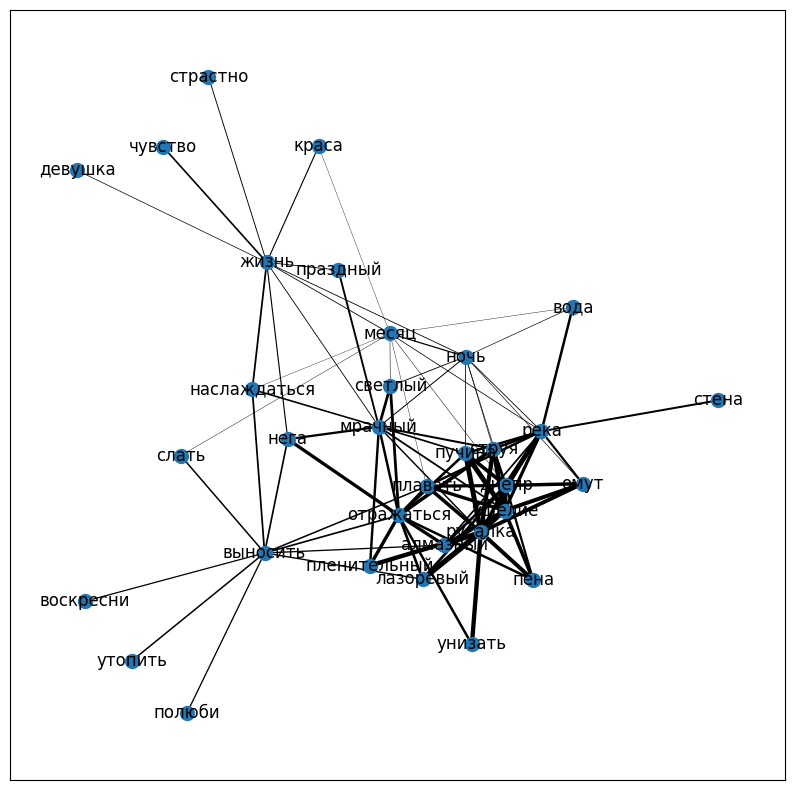

In [123]:
plt.figure(figsize=(10, 10))
graph = nx.Graph(graphs[10])
weights = np.array(list(nx.get_edge_attributes(graph, 'weight').values()))
nx.draw_networkx(graph, node_size=100, width=(weights + 0.5)**4)

In [126]:
core_edges = []
multiple_edges = []
boundary_edges = []
multiple_nodes = []
boundary_nodes = []

min_core_node_weight = []
max_core_node_weight = []
avg_core_node_weight = []
sum_core_node_weight = []
min_multiple_node_weight = []
max_multiple_node_weight = []
avg_multiple_node_weight = []
sum_multiple_node_weight = []
min_boundary_node_weight = []
max_boundary_node_weight = []
avg_boundary_node_weight = []
sum_boundary_node_weight = []

min_core_edge_weight = []
max_core_edge_weight = []
avg_core_edge_weight = []
sum_core_edge_weight = []
min_multiple_edge_weight = []
max_multiple_edge_weight = []
avg_multiple_edge_weight = []
sum_multiple_edge_weight = []
min_boundary_edge_weight = []
max_boundary_edge_weight = []
avg_boundary_edge_weight = []
sum_boundary_edge_weight = []

min_core_core_degree = []
max_core_core_degree = []
avg_core_core_degree = []
sum_core_core_degree = []
min_core_multiple_degree = []
max_core_multiple_degree = []
avg_core_multiple_degree = []
sum_core_multiple_degree = []
min_core_boundary_degree = []
max_core_boundary_degree = []
avg_core_boundary_degree = []
sum_core_boundary_degree = []

for graph in tqdm(graphs):
    edge_counter = Counter(nx.get_edge_attributes(graph, 'edge_type').values())
    node_counter = Counter(nx.get_node_attributes(graph, 'node_type').values())
    core_edges.append(edge_counter['core'])
    multiple_edges.append(edge_counter['multiple'])
    boundary_edges.append(edge_counter['boundary'])
    multiple_nodes.append(node_counter['multiple'])
    boundary_nodes.append(node_counter['boundary'])
    
    # node aggregation
    core_node_weight = []
    multiple_node_weight = []
    boundary_node_weight = []
    for node in graph.nodes:
        if graph.nodes[node]['node_type'] == 'core':
            core_node_weight.append(graph.nodes[node]['node_weight'])
        elif graph.nodes[node]['node_type'] == 'multiple':
            multiple_node_weight.append(graph.nodes[node]['node_weight'])
        else:
            boundary_node_weight.append(graph.nodes[node]['node_weight'])
    min_core_node_weight.append(min(core_node_weight))
    max_core_node_weight.append(max(core_node_weight))
    avg_core_node_weight.append(np.mean(core_node_weight))
    sum_core_node_weight.append(sum(core_node_weight))
    min_multiple_node_weight.append(min(multiple_node_weight, default=0))
    max_multiple_node_weight.append(max(multiple_node_weight, default=0))
    avg_multiple_node_weight.append(np.mean(multiple_node_weight))
    sum_multiple_node_weight.append(sum(multiple_node_weight))
    boundary_node_weight = [0] if not boundary_node_weight else boundary_node_weight
    min_boundary_node_weight.append(min(boundary_node_weight))
    max_boundary_node_weight.append(max(boundary_node_weight))
    avg_boundary_node_weight.append(np.mean(boundary_node_weight))
    sum_boundary_node_weight.append(sum(boundary_node_weight))
    
    # edge aggregation
    core_edge_weight = []
    multiple_edge_weight = []
    boundary_edge_weight = []
    for edge in graph.edges:
        if graph.edges[edge]['edge_type'] == 'core':
            core_edge_weight.append(graph.edges[edge]['weight'])
        elif graph.edges[edge]['edge_type'] == 'multiple':
            multiple_edge_weight.append(graph.edges[edge]['weight'])
        else:
            boundary_edge_weight.append(graph.edges[edge]['weight'])
    core_edge_weight = [0] if not core_edge_weight else core_edge_weight
    min_core_edge_weight.append(min(core_edge_weight))
    max_core_edge_weight.append(max(core_edge_weight))
    avg_core_edge_weight.append(np.mean(core_edge_weight))
    sum_core_edge_weight.append(sum(core_edge_weight))
    min_multiple_edge_weight.append(min(multiple_edge_weight, default=0))
    max_multiple_edge_weight.append(max(multiple_edge_weight, default=0))
    avg_multiple_edge_weight.append(np.mean(multiple_edge_weight))
    sum_multiple_edge_weight.append(sum(multiple_edge_weight))
    boundary_edge_weight = [0] if not boundary_edge_weight else boundary_edge_weight
    min_boundary_edge_weight.append(min(boundary_edge_weight))
    max_boundary_edge_weight.append(max(boundary_edge_weight))
    avg_boundary_edge_weight.append(np.mean(boundary_edge_weight))
    sum_boundary_edge_weight.append(sum(boundary_edge_weight))
    
    # degree aggregation
    core_core_degree = []
    core_multiple_degree = []
    core_boundary_degree = []
    for core_node in graph.nodes:
        if graph.nodes[core_node]['node_type'] != 'core':
            continue
        degree_counter = Counter([value for (u, v, value) in graph.edges(core_node, data='edge_type')])
        core_core_degree.append(degree_counter['core'])
        core_multiple_degree.append(degree_counter['multiple'])
        core_boundary_degree.append(degree_counter['boundary'])
    
    min_core_core_degree.append(min(core_core_degree))
    max_core_core_degree.append(max(core_core_degree))
    avg_core_core_degree.append(np.mean(core_core_degree))
    sum_core_core_degree.append(sum(core_core_degree))
    min_core_multiple_degree.append(min(core_multiple_degree))
    max_core_multiple_degree.append(max(core_multiple_degree))
    avg_core_multiple_degree.append(np.mean(core_multiple_degree))
    sum_core_multiple_degree.append(sum(core_multiple_degree))
    core_boundary_degree = [0] if not core_boundary_degree else core_boundary_degree
    min_core_boundary_degree.append(min(core_boundary_degree))
    max_core_boundary_degree.append(max(core_boundary_degree))
    avg_core_boundary_degree.append(np.mean(core_boundary_degree))
    sum_core_boundary_degree.append(sum(core_boundary_degree))

  0%|          | 0/1826 [00:00<?, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [127]:
graph_feat = pd.DataFrame({
    'text_len': text_len,
    'core_edges': core_edges,
    'multiple_edges': multiple_edges,
    'boundary_edges': boundary_edges,
    'multiple_nodes': multiple_nodes,
    'boundary_nodes': boundary_nodes,
    'min_core_node_weight': min_core_node_weight,
    'max_core_node_weight': max_core_node_weight,
    'avg_core_node_weight': avg_core_node_weight,
    'sum_core_node_weight': sum_core_node_weight,
    'min_multiple_node_weight': min_multiple_node_weight,
    'max_multiple_node_weight': max_multiple_node_weight,
    'avg_multiple_node_weight': avg_multiple_node_weight,
    'sum_multiple_node_weight': sum_multiple_node_weight,
    'min_boundary_node_weight': min_boundary_node_weight,
    'max_boundary_node_weight': max_boundary_node_weight,
    'avg_boundary_node_weight': avg_boundary_node_weight,
    'sum_boundary_node_weight': sum_boundary_node_weight,
    'min_core_edge_weight': min_core_edge_weight,
    'max_core_edge_weight': max_core_edge_weight,
    'avg_core_edge_weight': avg_core_edge_weight,
    'sum_core_edge_weight': sum_core_edge_weight,
    'min_multiple_edge_weight': min_multiple_edge_weight,
    'max_multiple_edge_weight': max_multiple_edge_weight,
    'avg_multiple_edge_weight': avg_multiple_edge_weight,
    'sum_multiple_edge_weight': sum_multiple_edge_weight,
    'min_boundary_edge_weight': min_boundary_edge_weight,
    'max_boundary_edge_weight': max_boundary_edge_weight,
    'avg_boundary_edge_weight': avg_boundary_edge_weight,
    'sum_boundary_edge_weight': sum_boundary_edge_weight,
    'min_core_core_degree': min_core_core_degree,
    'max_core_core_degree': max_core_core_degree,
    'avg_core_core_degree': avg_core_core_degree,
    'sum_core_core_degree': sum_core_core_degree,
    'min_core_multiple_degree': min_core_multiple_degree,
    'max_core_multiple_degree': max_core_multiple_degree,
    'avg_core_multiple_degree': avg_core_multiple_degree,
    'sum_core_multiple_degree': sum_core_multiple_degree,
    'min_core_boundary_degree': min_core_boundary_degree,
    'max_core_boundary_degree': max_core_boundary_degree,
    'avg_core_boundary_degree': avg_core_boundary_degree,
    'sum_core_boundary_degree': sum_core_boundary_degree,
})
graph_feat.iloc[0]

text_len                    154.000000
core_edges                   24.000000
multiple_edges               39.000000
boundary_edges               18.000000
multiple_nodes               12.000000
boundary_nodes               18.000000
min_core_node_weight          0.019481
max_core_node_weight          0.045455
avg_core_node_weight          0.035065
sum_core_node_weight          0.350649
min_multiple_node_weight      0.006494
max_multiple_node_weight      0.012987
avg_multiple_node_weight      0.010281
sum_multiple_node_weight      0.123377
min_boundary_node_weight      0.006494
max_boundary_node_weight      0.012987
avg_boundary_node_weight      0.007576
sum_boundary_node_weight      0.136364
min_core_edge_weight          0.574535
max_core_edge_weight          0.958177
avg_core_edge_weight          0.832050
sum_core_edge_weight         19.969193
min_multiple_edge_weight      0.380254
max_multiple_edge_weight      0.862086
avg_multiple_edge_weight      0.740866
sum_multiple_edge_weight 

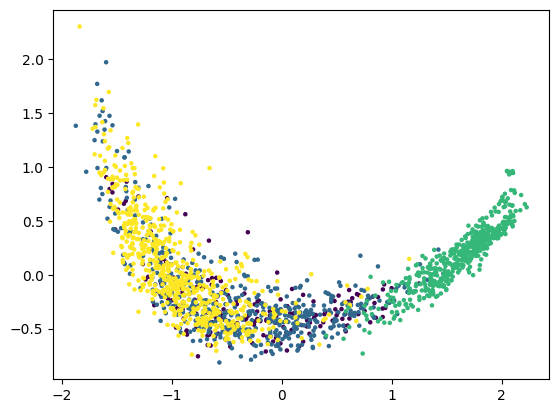

In [129]:
pca = PCA(n_components=16)
emb = pca.fit_transform(minmax_scale(np.nan_to_num(graph_feat)))
plt.scatter(emb[:, 0], emb[:, 1], c=LabelEncoder().fit_transform(true_labels), s=5)

In [130]:
clustering = SpectralClustering(
    n_clusters=4, 
    n_neighbors=6,
    affinity='nearest_neighbors',
    assign_labels='kmeans',
)
pred_labels = clustering.fit_predict(emb)

print(
f'''homogeneity_score: {metrics.homogeneity_score(true_labels, pred_labels):.4f}
completeness_score: {metrics.completeness_score(true_labels, pred_labels):.4f}
v_measure_score: {metrics.v_measure_score(true_labels, pred_labels):.4f}
adjusted_rand_score: {metrics.adjusted_rand_score(true_labels, pred_labels):.4f}'''
)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


homogeneity_score: 0.4174
completeness_score: 0.7995
v_measure_score: 0.5485
adjusted_rand_score: 0.3827


authors for novels

In [2]:
class Dataloader:
    def __iter__(self):
        for genre in ['ballads', 'elegies', 'songs', 'novels']:
            for file in os.listdir('../datasets/lemmatized/' + genre):
                with open('../datasets/lemmatized/' + genre + '/' + file, 'r', encoding='utf-8') as f:
                    fname = '../datasets/lemmatized/' + genre + '/' + file
                    if genre == 'novels':
                        author = file.split('.')[0]
                    elif genre == 'ballads':
                        author = file.split('_')[2]
                    else:
                        author = file.split('_')[1]
                    yield utils.simple_preprocess(f.read()), genre, author, fname
sentences = Dataloader()

fnames = []
texts = []
true_labels = []
authors = []

for (sent, genre, author, fname) in sentences:
    if not sent:
        continue
    texts. append(sent)
    true_labels.append(genre)
    authors.append(author)
    fnames.append(fname)

In [3]:
novels = [num for num, genre in enumerate(true_labels) if genre == 'novels']
novels_text = [text for num, text in enumerate(texts) if num in novels]
novels_authors = [text for num, text in enumerate(authors) if num in novels]
selected_authors = [i[0] for i in Counter(novels_authors).most_common(10)]
indeces = [num for num, author in enumerate(authors) if author in selected_authors]

sentences = [texts[num] for num in indeces]

In [17]:
true_labels = [authors[num] for num in indeces]

In [4]:
word2vec = gensim.models.Word2Vec.load('word2vec_model')
wv = word2vec.wv

In [5]:
graphs = []
text_len = []
true_labels = []

for num_sentence, sentence in enumerate(sentences):
    #if num_sentence not in random_num:
    #    continue
    if not sentence:
        continue
    text_len.append(len(sentence))
    node_type = dict()
    edge_type = dict()
    node_weight = dict()
    nodes = []
    edges = []
    weights = []
    counter = Counter(sentence)
    top10 = counter.most_common(10)
    for word_i, count in top10:
        nodes.append(word_i)
        node_weight[word_i] = count / len(sentence)
        node_type[word_i] = 'core'
        words_in_text = np.array(list(set(sentence)))
        sim = wv.cosine_similarities(wv[word_i], wv[words_in_text])
        neigh_idx = np.argsort(sim)[-11:-1]
        for j in neigh_idx:
            word_j = words_in_text[j]
            if word_j not in nodes:
                nodes.append(word_j)
                node_weight[word_j] = counter[word_j] / len(sentence)
            edges.append([word_i, word_j, sim[j]])
    graph = nx.Graph()
    graph.add_nodes_from(nodes)
    graph.add_weighted_edges_from(edges)
    for node, degree in graph.degree:
        if degree == 1:
            node_type[node] = 'boundary'
    for node in set(graph.nodes).difference(node_type.keys()):
        node_type[node] = 'multiple'
    nx.set_node_attributes(graph, node_type, 'node_type')
    nx.set_node_attributes(graph, node_weight, 'node_weight')
    for (u, v) in graph.edges:
        types = set(nx.get_node_attributes(graph.subgraph([u, v]), 'node_type').values())
        if types == {'core'}:
            edge_type[(u, v)] = 'core'
        elif types == {'core', 'multiple'}:
            edge_type[(u, v)] = 'multiple'
        else:
            edge_type[(u, v)] = 'boundary'
    nx.set_edge_attributes(graph, edge_type, 'edge_type')
    graphs.append(graph)

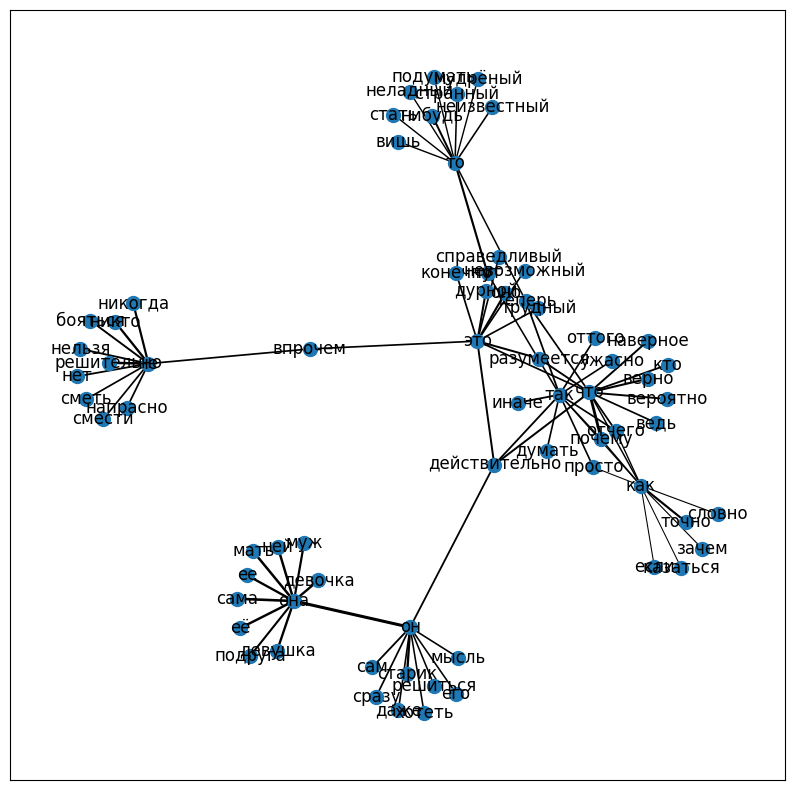

In [9]:
plt.figure(figsize=(10, 10))
graph = nx.Graph(graphs[1])
cc_nodes = list(nx.connected_components(graph))[0]
subgraph = graph.subgraph(cc_nodes)
weights = np.array(list(nx.get_edge_attributes(subgraph, 'weight').values()))
nx.draw_networkx(subgraph, node_size=100, width=(weights + 0.5)**4)

In [10]:
core_edges = []
multiple_edges = []
boundary_edges = []
multiple_nodes = []
boundary_nodes = []

min_core_node_weight = []
max_core_node_weight = []
avg_core_node_weight = []
sum_core_node_weight = []
min_multiple_node_weight = []
max_multiple_node_weight = []
avg_multiple_node_weight = []
sum_multiple_node_weight = []
min_boundary_node_weight = []
max_boundary_node_weight = []
avg_boundary_node_weight = []
sum_boundary_node_weight = []

min_core_edge_weight = []
max_core_edge_weight = []
avg_core_edge_weight = []
sum_core_edge_weight = []
min_multiple_edge_weight = []
max_multiple_edge_weight = []
avg_multiple_edge_weight = []
sum_multiple_edge_weight = []
min_boundary_edge_weight = []
max_boundary_edge_weight = []
avg_boundary_edge_weight = []
sum_boundary_edge_weight = []

min_core_core_degree = []
max_core_core_degree = []
avg_core_core_degree = []
sum_core_core_degree = []
min_core_multiple_degree = []
max_core_multiple_degree = []
avg_core_multiple_degree = []
sum_core_multiple_degree = []
min_core_boundary_degree = []
max_core_boundary_degree = []
avg_core_boundary_degree = []
sum_core_boundary_degree = []

for graph in tqdm(graphs):
    edge_counter = Counter(nx.get_edge_attributes(graph, 'edge_type').values())
    node_counter = Counter(nx.get_node_attributes(graph, 'node_type').values())
    core_edges.append(edge_counter['core'])
    multiple_edges.append(edge_counter['multiple'])
    boundary_edges.append(edge_counter['boundary'])
    multiple_nodes.append(node_counter['multiple'])
    boundary_nodes.append(node_counter['boundary'])
    
    # node aggregation
    core_node_weight = []
    multiple_node_weight = []
    boundary_node_weight = []
    for node in graph.nodes:
        if graph.nodes[node]['node_type'] == 'core':
            core_node_weight.append(graph.nodes[node]['node_weight'])
        elif graph.nodes[node]['node_type'] == 'multiple':
            multiple_node_weight.append(graph.nodes[node]['node_weight'])
        else:
            boundary_node_weight.append(graph.nodes[node]['node_weight'])
    min_core_node_weight.append(min(core_node_weight))
    max_core_node_weight.append(max(core_node_weight))
    avg_core_node_weight.append(np.mean(core_node_weight))
    sum_core_node_weight.append(sum(core_node_weight))
    min_multiple_node_weight.append(min(multiple_node_weight))
    max_multiple_node_weight.append(max(multiple_node_weight))
    avg_multiple_node_weight.append(np.mean(multiple_node_weight))
    sum_multiple_node_weight.append(sum(multiple_node_weight))
    boundary_node_weight = [0] if not boundary_node_weight else boundary_node_weight
    min_boundary_node_weight.append(min(boundary_node_weight))
    max_boundary_node_weight.append(max(boundary_node_weight))
    avg_boundary_node_weight.append(np.mean(boundary_node_weight))
    sum_boundary_node_weight.append(sum(boundary_node_weight))
    
    # edge aggregation
    core_edge_weight = []
    multiple_edge_weight = []
    boundary_edge_weight = []
    for edge in graph.edges:
        if graph.edges[edge]['edge_type'] == 'core':
            core_edge_weight.append(graph.edges[edge]['weight'])
        elif graph.edges[edge]['edge_type'] == 'multiple':
            multiple_edge_weight.append(graph.edges[edge]['weight'])
        else:
            boundary_edge_weight.append(graph.edges[edge]['weight'])
    core_edge_weight = [0] if not core_edge_weight else core_edge_weight
    min_core_edge_weight.append(min(core_edge_weight))
    max_core_edge_weight.append(max(core_edge_weight))
    avg_core_edge_weight.append(np.mean(core_edge_weight))
    sum_core_edge_weight.append(sum(core_edge_weight))
    min_multiple_edge_weight.append(min(multiple_edge_weight))
    max_multiple_edge_weight.append(max(multiple_edge_weight))
    avg_multiple_edge_weight.append(np.mean(multiple_edge_weight))
    sum_multiple_edge_weight.append(sum(multiple_edge_weight))
    boundary_edge_weight = [0] if not boundary_edge_weight else boundary_edge_weight
    min_boundary_edge_weight.append(min(boundary_edge_weight))
    max_boundary_edge_weight.append(max(boundary_edge_weight))
    avg_boundary_edge_weight.append(np.mean(boundary_edge_weight))
    sum_boundary_edge_weight.append(sum(boundary_edge_weight))
    
    # degree aggregation
    core_core_degree = []
    core_multiple_degree = []
    core_boundary_degree = []
    for core_node in graph.nodes:
        if graph.nodes[core_node]['node_type'] != 'core':
            continue
        degree_counter = Counter([value for (u, v, value) in graph.edges(core_node, data='edge_type')])
        core_core_degree.append(degree_counter['core'])
        core_multiple_degree.append(degree_counter['multiple'])
        core_boundary_degree.append(degree_counter['boundary'])
    
    min_core_core_degree.append(min(core_core_degree))
    max_core_core_degree.append(max(core_core_degree))
    avg_core_core_degree.append(np.mean(core_core_degree))
    sum_core_core_degree.append(sum(core_core_degree))
    min_core_multiple_degree.append(min(core_multiple_degree))
    max_core_multiple_degree.append(max(core_multiple_degree))
    avg_core_multiple_degree.append(np.mean(core_multiple_degree))
    sum_core_multiple_degree.append(sum(core_multiple_degree))
    core_boundary_degree = [0] if not core_boundary_degree else core_boundary_degree
    min_core_boundary_degree.append(min(core_boundary_degree))
    max_core_boundary_degree.append(max(core_boundary_degree))
    avg_core_boundary_degree.append(np.mean(core_boundary_degree))
    sum_core_boundary_degree.append(sum(core_boundary_degree))

  0%|          | 0/148 [00:00<?, ?it/s]

In [11]:
graph_feat = pd.DataFrame({
    'text_len': text_len,
    'core_edges': core_edges,
    'multiple_edges': multiple_edges,
    'boundary_edges': boundary_edges,
    'multiple_nodes': multiple_nodes,
    'boundary_nodes': boundary_nodes,
    'min_core_node_weight': min_core_node_weight,
    'max_core_node_weight': max_core_node_weight,
    'avg_core_node_weight': avg_core_node_weight,
    'sum_core_node_weight': sum_core_node_weight,
    'min_multiple_node_weight': min_multiple_node_weight,
    'max_multiple_node_weight': max_multiple_node_weight,
    'avg_multiple_node_weight': avg_multiple_node_weight,
    'sum_multiple_node_weight': sum_multiple_node_weight,
    'min_boundary_node_weight': min_boundary_node_weight,
    'max_boundary_node_weight': max_boundary_node_weight,
    'avg_boundary_node_weight': avg_boundary_node_weight,
    'sum_boundary_node_weight': sum_boundary_node_weight,
    'min_core_edge_weight': min_core_edge_weight,
    'max_core_edge_weight': max_core_edge_weight,
    'avg_core_edge_weight': avg_core_edge_weight,
    'sum_core_edge_weight': sum_core_edge_weight,
    'min_multiple_edge_weight': min_multiple_edge_weight,
    'max_multiple_edge_weight': max_multiple_edge_weight,
    'avg_multiple_edge_weight': avg_multiple_edge_weight,
    'sum_multiple_edge_weight': sum_multiple_edge_weight,
    'min_boundary_edge_weight': min_boundary_edge_weight,
    'max_boundary_edge_weight': max_boundary_edge_weight,
    'avg_boundary_edge_weight': avg_boundary_edge_weight,
    'sum_boundary_edge_weight': sum_boundary_edge_weight,
    'min_core_core_degree': min_core_core_degree,
    'max_core_core_degree': max_core_core_degree,
    'avg_core_core_degree': avg_core_core_degree,
    'sum_core_core_degree': sum_core_core_degree,
    'min_core_multiple_degree': min_core_multiple_degree,
    'max_core_multiple_degree': max_core_multiple_degree,
    'avg_core_multiple_degree': avg_core_multiple_degree,
    'sum_core_multiple_degree': sum_core_multiple_degree,
    'min_core_boundary_degree': min_core_boundary_degree,
    'max_core_boundary_degree': max_core_boundary_degree,
    'avg_core_boundary_degree': avg_core_boundary_degree,
    'sum_core_boundary_degree': sum_core_boundary_degree,
})
graph_feat.iloc[0]

text_len                    183166.000000
core_edges                       3.000000
multiple_edges                  19.000000
boundary_edges                  78.000000
multiple_nodes                   8.000000
boundary_nodes                  78.000000
min_core_node_weight             0.009685
max_core_node_weight             0.028362
avg_core_node_weight             0.015333
sum_core_node_weight             0.153331
min_multiple_node_weight         0.000082
max_multiple_node_weight         0.003625
avg_multiple_node_weight         0.000978
sum_multiple_node_weight         0.007824
min_boundary_node_weight         0.000005
max_boundary_node_weight         0.007376
avg_boundary_node_weight         0.000881
sum_boundary_node_weight         0.068703
min_core_edge_weight             0.512265
max_core_edge_weight             0.551240
avg_core_edge_weight             0.530462
sum_core_edge_weight             1.591387
min_multiple_edge_weight         0.493182
max_multiple_edge_weight         0

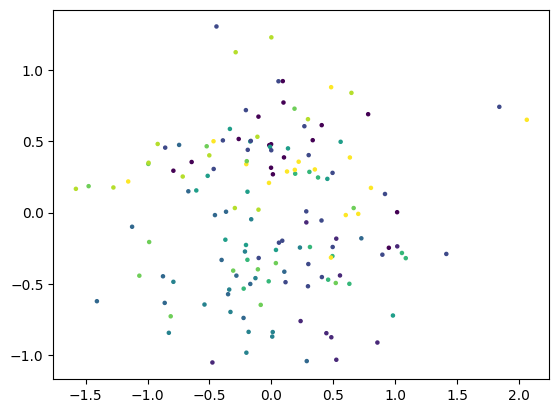

In [19]:
pca = PCA(n_components=16)
emb = pca.fit_transform(minmax_scale(graph_feat))
plt.scatter(emb[:, 0], emb[:, 1], c=LabelEncoder().fit_transform(true_labels), s=5)

In [20]:
clustering = SpectralClustering(
    n_clusters=4, 
    n_neighbors=6,
    affinity='nearest_neighbors',
    assign_labels='kmeans',
)
pred_labels = clustering.fit_predict(emb)

In [21]:
print(
f'''homogeneity_score: {metrics.homogeneity_score(true_labels, pred_labels):.4f}
completeness_score: {metrics.completeness_score(true_labels, pred_labels):.4f}
v_measure_score: {metrics.v_measure_score(true_labels, pred_labels):.4f}
adjusted_rand_score: {metrics.adjusted_rand_score(true_labels, pred_labels):.4f}'''
)

homogeneity_score: 0.2226
completeness_score: 0.3678
v_measure_score: 0.2773
adjusted_rand_score: 0.1451
